<a href="https://colab.research.google.com/github/mart-anthony-stark/Machine-Learning-Daily/blob/main/Titanic_dataset_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [49]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
# Data wrangling
import pandas as pd
import numpy as np
import missingno
from collections import Counter

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Model evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [51]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')
submission_data = pd.read_csv('gender_submission.csv')

## Show first 5 rows from the dataset

In [52]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [53]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [54]:
print('Training set: ', train_data.shape)
print('Testing set: ', test_data.shape) # Dropped target column (Survived)

Training set:  (891, 12)
Testing set:  (418, 11)


In [55]:
submission_data.head() 
print(submission_data.shape) # Must have the same shape with the final submission

(418, 2)


## Features
- Survival: 0 = Did not survive, 1 = Survived
- Pclass: Ticket class where 1 = First class, 2 = Second class, 3 = Third class. This can also be seen as a proxy for socio-economic status.
- Sex: Male or female
- Age: Age in years, fractional if less than 1
- SibSp: Number of siblings or spouses aboard the titanic
- Parch: Number of parents or children aboard the titanic
- Ticket: Passenger ticket number
- Fare: Passenger fare
- Cabin: Cabin number
- Embarked: Point of embarkation where C = Cherbourg, Q = Queenstown, S = Southampton

## Variable Notes
- pclass: A proxy for socio-economic status (SES)
1. 1st = Upper
2. 2nd = Middle
3. 3rd = Lower

- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- sibsp: The dataset defines family relations in this way...
1. Sibling = brother, sister, stepbrother, stepsister
2. Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: The dataset defines family relations in this way...
1. Parent = mother, father
2. Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## Exploratory Data Analysis

In [56]:
print("Training data")
print("-"*50)
train_data.info()
print("-"*50)
print("Testing data")
print("-"*50)
test_data.info()

Training data
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------------------------------------
Testing data
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0

### Check the counts null values as per column

In [57]:
# Training dataset null values
train_data.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [58]:
# Testing dataset null values
test_data.isnull().sum().sort_values(ascending=False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

### Missing values
- Training data null values: Cabin, Age, Embarked
- Testing data null values: Cabin, Age , Fare

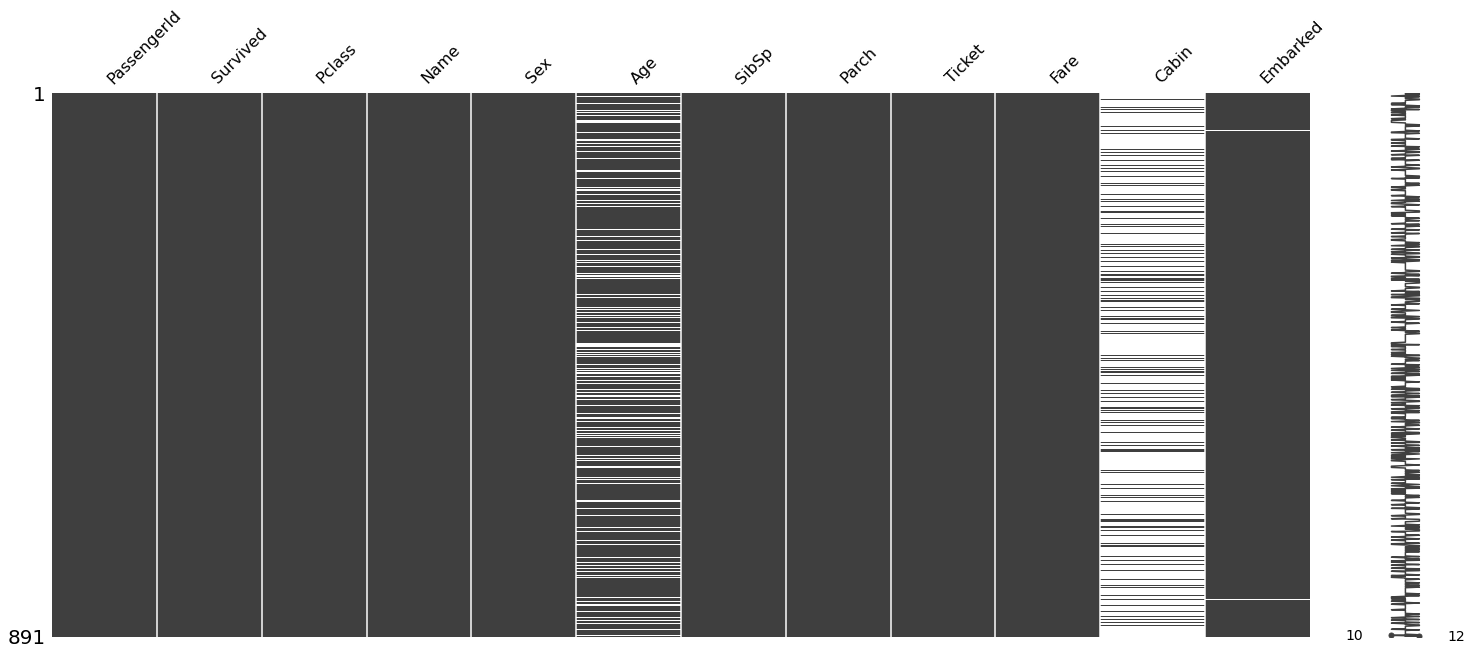

In [59]:
# Using missingno library
missingno.matrix(train_data)
plt.show()

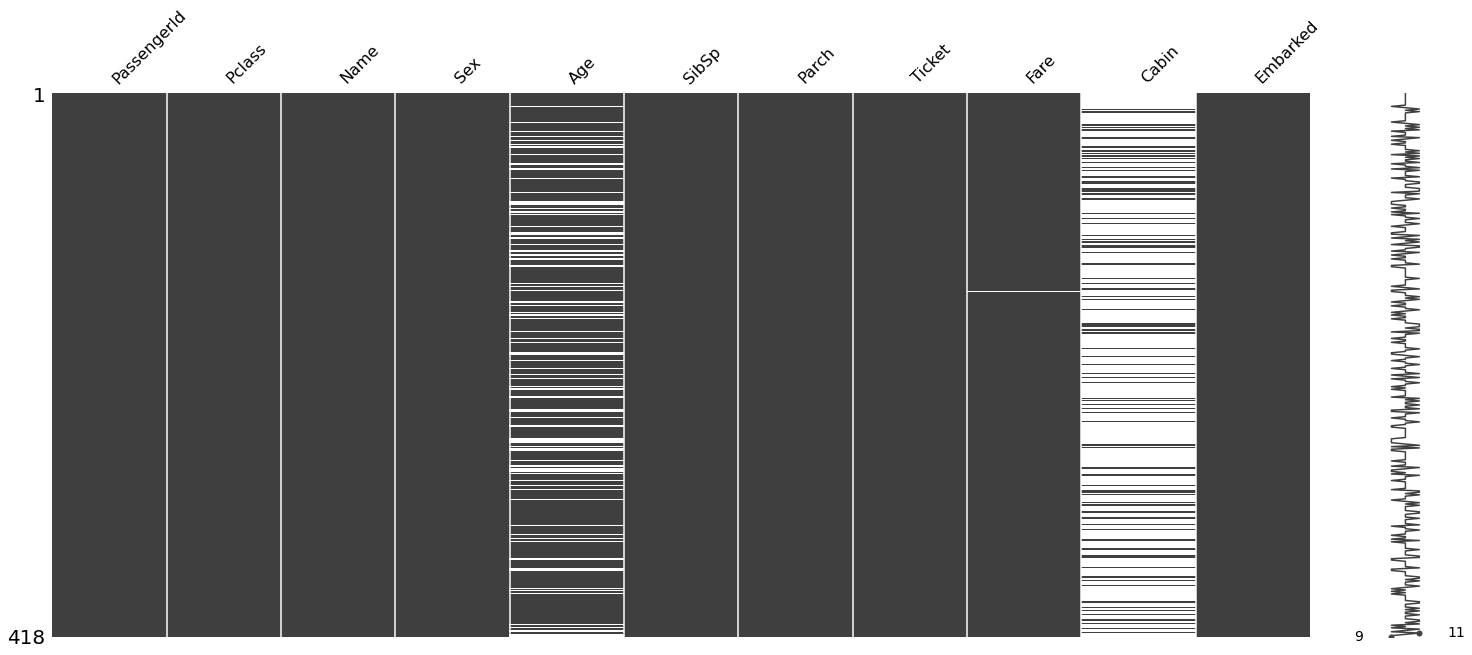

In [60]:
# Using missingno library
missingno.matrix(test_data)
plt.show()

### Overall Statistics

In [61]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [62]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## Feature Analysis

1. Categorical Variables


> - Sex
> - Pclass
> - Embarked





### Categorical: Sex

In [63]:
train_data['Sex'].value_counts(dropna=False)

male      577
female    314
Name: Sex, dtype: int64

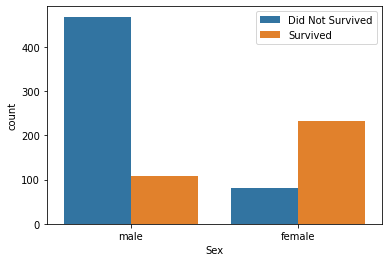

In [64]:
sns.countplot(x='Sex', hue='Survived', data=train_data)
plt.legend(['Did Not Survived', 'Survived'])
plt.show()

In [65]:
# Mean of survival
train_data[['Sex', 'Survived']].groupby('Sex', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


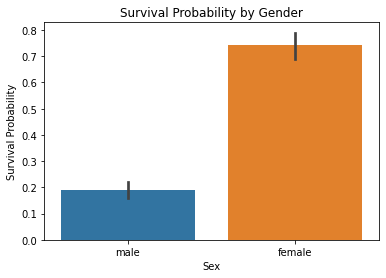

In [66]:
sns.barplot(x='Sex', y='Survived', data=train_data)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Gender')
plt.show()

> Female passengers are the priority for evacuation because of code of conduct "Women and Children First"

### Categorical: Pclass

In [67]:
train_data['Pclass'].value_counts(dropna=False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [68]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


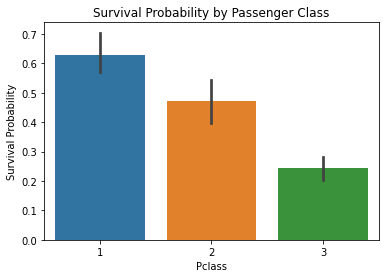

In [69]:
sns.barplot(x='Pclass', y='Survived', data=train_data)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class')
plt.show()

> Survival Probability is highest on Upper class passengers

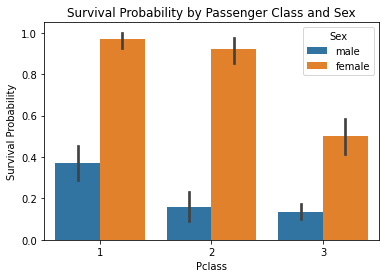

In [70]:
sns.barplot(x='Pclass', y='Survived',hue='Sex', data=train_data)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class and Sex')
plt.show()

### Categorical: Embarked

In [71]:
train_data['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [72]:
train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


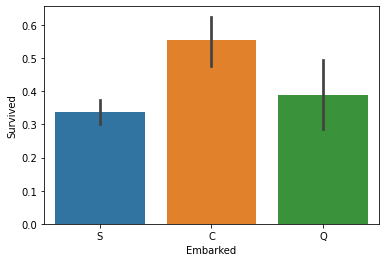

In [73]:
sns.barplot(x='Embarked', y='Survived', data=train_data)
plt.show()

Survival probability is Highest on location C and lowest on location S

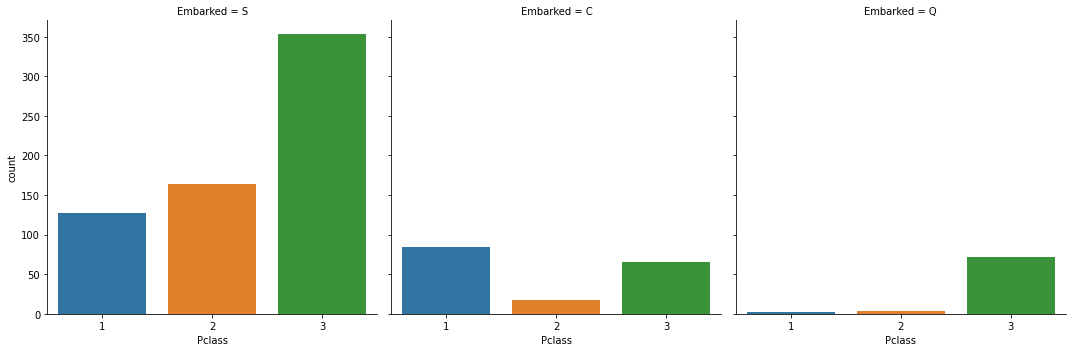

In [74]:
sns.factorplot('Pclass', col='Embarked', data=train_data, kind='count')

### Plot probability of all categorical features

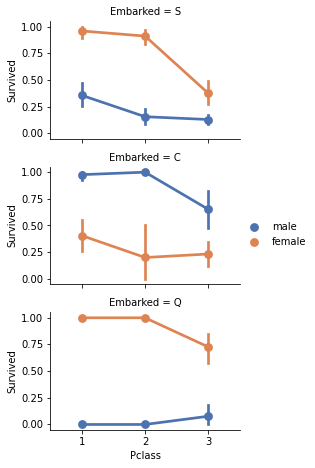

In [75]:
# Survival probability by all categorical variables

grid = sns.FacetGrid(train_data, row = 'Embarked', size = 2.2, aspect = 1.6)
grid.map(sns.pointplot,'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

## Numerical Variables
- SibSp
- Parch
- Age
- Fare

### Detect and remove outliers
This function will loop through a list of features and detect outliers in each one of those features. In each
    loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds
    third quartile plus the outlier step. The outlier step is defined as 1.5 times the interquartile range. Once the 
    outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next
    feature and the process repeats until the very last feature is completed. Finally, using the list with outlier 
    indices, we will count the frequencies of the index numbers and return them if their frequency exceeds n times. 

In [76]:
def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(train_data, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)
# We will drop these 10 indices:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

# Outliers in numerical variables
train_data.loc[outliers_to_drop, :]

We will drop these 10 indices:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [77]:
train_data.shape

(891, 12)

In [78]:
# Drop outliers and reset index

print("Before: {} rows".format(len(train_data)))
train = train_data.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(train)))

Before: 891 rows
After: 881 rows


### Numerical variables correlation with survival

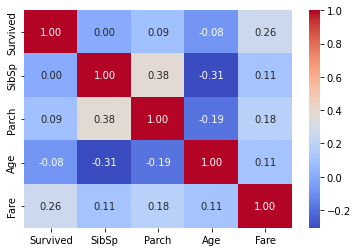

In [79]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

# Comment: Fare seems to be the only feature that has a substantial correlation with survival

### Numerical: SibSp

In [80]:
# Value counts of the SibSp column 

train['SibSp'].value_counts(dropna = False)

0    608
1    209
2     28
4     18
3     13
5      5
Name: SibSp, dtype: int64

In [81]:
# Mean of survival by SibSp

train[['SibSp', 'Survived']].groupby('SibSp', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


Text(0.5, 1.0, 'Survival Probability by SibSp')

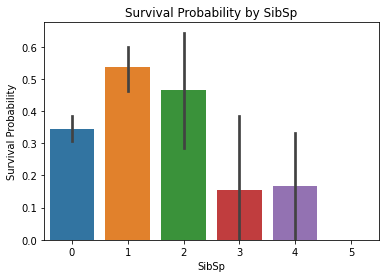

In [82]:
sns.barplot(x = 'SibSp', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

### Numerical: Parch

In [83]:
# Value counts of the Parch column 

train['Parch'].value_counts(dropna = False)

0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [84]:
# Mean of survival by Parch

train[['Parch', 'Survived']].groupby('Parch', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Text(0.5, 1.0, 'Survival Probability by Parch')

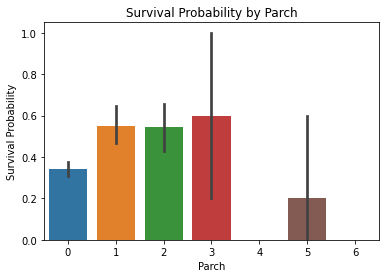

In [85]:
sns.barplot(x = 'Parch', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Parch')

### Numerical variable: Age

In [86]:
# Null values in Age column 

train['Age'].isnull().sum()

170

Text(0.5, 1.0, 'Passenger Age Distribution')

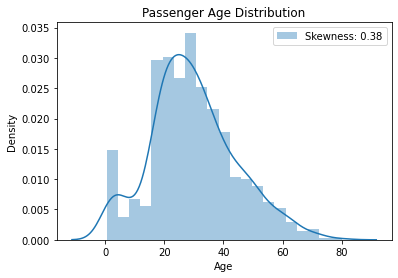

In [87]:
# Passenger age distribution

sns.distplot(train['Age'], label = 'Skewness: %.2f'%(train['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

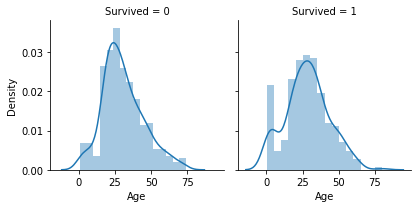

In [88]:
# Age distribution by survival

g = sns.FacetGrid(train, col = 'Survived')
g.map(sns.distplot, 'Age')

Text(0.5, 1.0, 'Passenger Age Distribution by Survival')

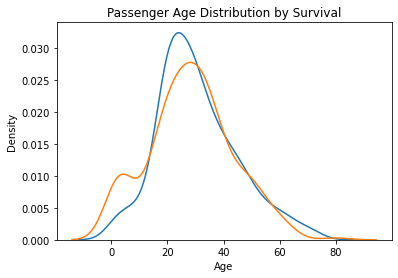

In [89]:
sns.kdeplot(train['Age'][train['Survived'] == 0], label = 'Did not survive')
sns.kdeplot(train['Age'][train['Survived'] == 1], label = 'Survived')
plt.xlabel('Age')
plt.title('Passenger Age Distribution by Survival')

### Numerical variable: Fare

In [90]:
# Null values of Fare column 

train['Fare'].isnull().sum()

0

Text(0, 0.5, 'Passenger Fare Distribution')

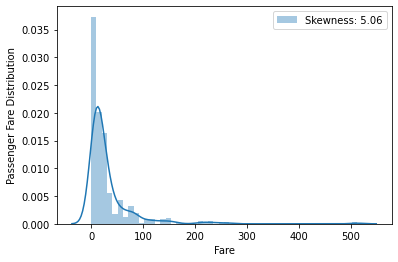

In [91]:
# Passenger fare distribution

sns.distplot(train['Fare'], label = 'Skewness: %.2f'%(train['Fare'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Fare Distribution')

# Data Preprocessing

## Drop and fill missing values

In [92]:
# Drop ticket and cabin features from training and testing dataset
train = train.drop(['Ticket', 'Cabin'], axis=1)

In [94]:
test = test_data.drop(['Ticket', 'Cabin'], axis=1)


In [96]:
# Missing values in dataset
train.isnull().sum().sort_values(ascending=False)

Age            170
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
dtype: int64

In [97]:
# Compute the most frequent value of Embarked in training set

mode = train['Embarked'].dropna().mode()[0]
mode

'S'

In [98]:
# Fill missing value in Embarked with mode

train['Embarked'].fillna(mode, inplace = True)

In [99]:
# Missing values in test set

test.isnull().sum().sort_values(ascending = False)

Age            86
Fare            1
PassengerId     0
Pclass          0
Name            0
Sex             0
SibSp           0
Parch           0
Embarked        0
dtype: int64

In [100]:
# Compute median of Fare in test set 

median = test['Fare'].dropna().median()
median

14.4542

In [101]:
# Fill missing value in Fare with median

test['Fare'].fillna(median, inplace = True)

In [102]:
# Combine training set and test set

combine = pd.concat([train, test], axis = 0).reset_index(drop = True)
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [103]:
# Missing values in the combined dataset

combine.isnull().sum().sort_values(ascending = False)

Survived       418
Age            256
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

In [104]:
# Convert Sex into numerical values where 0 = male and 1 = female

combine['Sex'] = combine['Sex'].map({'male': 0, 'female': 1})

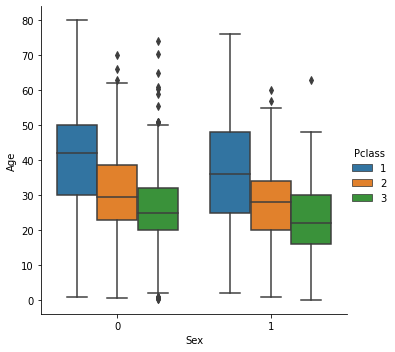

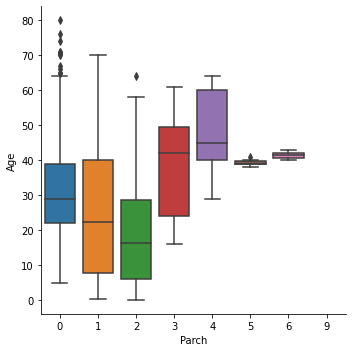

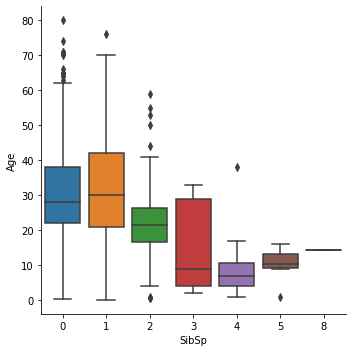

In [105]:
sns.factorplot(y = 'Age', x = 'Sex', hue = 'Pclass', kind = 'box', data = combine)
sns.factorplot(y = 'Age', x = 'Parch', kind = 'box', data = combine)
sns.factorplot(y = 'Age', x = 'SibSp', kind = 'box', data = combine)

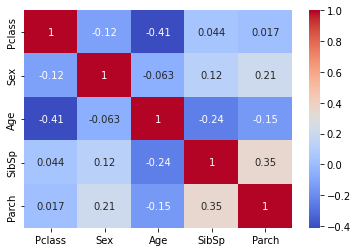

In [106]:
sns.heatmap(combine.drop(['Survived', 'Name', 'PassengerId', 'Fare'], axis = 1).corr(), annot = True, cmap = 'coolwarm')

Age is not correlated with Sex but is negatively correlated with SibSp, Parch and Pclass.

In [107]:
# Check number of missing ages 

age_nan_indices = list(combine[combine['Age'].isnull()].index)
len(age_nan_indices)

256

Loop through each missing age in the list to locate the rows that have the same SibSp, Parch and PClass values and fill the missing age with the median of those rows. If rows are not found, simply fill the missing age with the median of the entire Age column.

In [108]:
# Loop through list and impute missing ages

for index in age_nan_indices:
    median_age = combine['Age'].median()
    predict_age = combine['Age'][(combine['SibSp'] == combine.iloc[index]['SibSp']) 
                                 & (combine['Parch'] == combine.iloc[index]['Parch'])
                                 & (combine['Pclass'] == combine.iloc[index]["Pclass"])].median()
    if np.isnan(predict_age):
        combine['Age'].iloc[index] = median_age
    else:
        combine['Age'].iloc[index] = predict_age

In [109]:
# Make sure there is no more missing ages 

combine['Age'].isnull().sum()

0

## Data transformation
Recall that our passenger fare column has a very high positive skewness. Therefore, we will apply a log transformation to address this issue.

Text(0.5, 1.0, 'Passenger Fare Distribution')

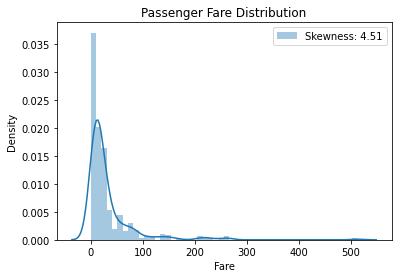

In [110]:
# Passenger fare distribution

sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution')

In [111]:
# Apply log transformation to Fare column to reduce skewness

combine['Fare'] = combine['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

Text(0.5, 1.0, 'Passenger Fare Distribution After Log Transformation')

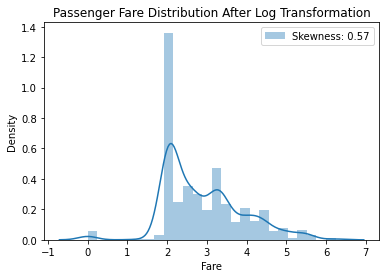

In [112]:
# Passenger fare distribution after log transformation

sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution After Log Transformation')

## Feature engineering
Feature engineering is arguably the most important art in machine learning. It is the process of creating new features from existing features to better represent the underlying problem to the predictive models resulting in improved model accuracy on unseen data.
- Title
- IsAlone
- Age*Class

### Title

In [113]:
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1.981001,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,4.266662,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,2.070022,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,3.972177,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,2.085672,S


In [114]:
# Get title from name

combine['Title'] = [name.split(',')[1].split('.')[0].strip() for name in combine['Name']]
combine[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [115]:
# Value counts of Title

combine['Title'].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [116]:
# Number of unique Title

combine['Title'].nunique()

18

In [117]:
# Simplify title

combine['Title'] = combine['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Jonkheer', 'Don', 'Capt', 'the Countess',
                                             'Sir', 'Dona'], 'Rare')
combine['Title'] = combine['Title'].replace(['Mlle', 'Ms'], 'Miss')
combine['Title'] = combine['Title'].replace('Mme', 'Mrs')

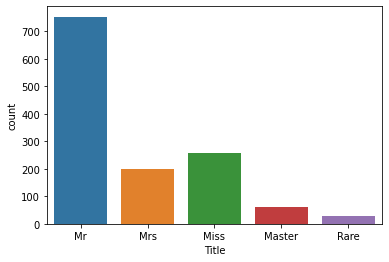

In [118]:
sns.countplot(combine['Title'])

In [119]:
# Mean of survival by name title

combine[['Title', 'Survived']].groupby(['Title'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.711111
0,Master,0.589744
4,Rare,0.347826
2,Mr,0.157895


Text(0.5, 1.0, 'Mean of survival by Title')

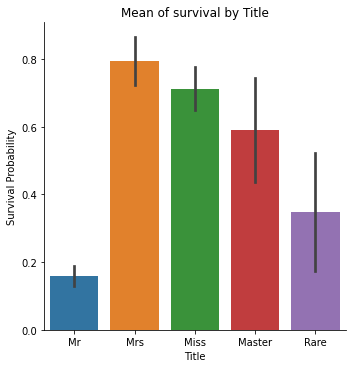

In [120]:
sns.factorplot(x = 'Title', y = 'Survived', data = combine, kind = 'bar')
plt.ylabel('Survival Probability')
plt.title('Mean of survival by Title')

In [121]:
# Drop name column

combine = combine.drop('Name', axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,3,0,22.0,1,0,1.981001,S,Mr
1,2,1.0,1,1,38.0,1,0,4.266662,C,Mrs
2,3,1.0,3,1,26.0,0,0,2.070022,S,Miss
3,4,1.0,1,1,35.0,1,0,3.972177,S,Mrs
4,5,0.0,3,0,35.0,0,0,2.085672,S,Mr


### IsAlone

In [122]:
# Calculate family size from SibSp and Parch

combine['FamilySize'] = combine['SibSp'] + combine['Parch'] + 1
combine[['SibSp', 'Parch', 'FamilySize']].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


In [123]:
# Mean of survival by family size

combine[['FamilySize', 'Survived']].groupby('FamilySize', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.052632
7,8,0.000000
8,11,NaN


In [124]:
# Create IsAlone feature

combine['IsAlone'] = 0
combine.loc[combine['FamilySize'] == 1, 'IsAlone'] = 1

In [125]:
# Mean of survival by IsAlone

combine[['IsAlone', 'Survived']].groupby('IsAlone', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,IsAlone,Survived
0,0,0.514535
1,1,0.303538


In [126]:
# Drop SibSp, Parch and FamilySize features from combine dataframe

combine = combine.drop(['SibSp', 'Parch', 'FamilySize'], axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,1,0.0,3,0,22.0,1.981001,S,Mr,0
1,2,1.0,1,1,38.0,4.266662,C,Mrs,0
2,3,1.0,3,1,26.0,2.070022,S,Miss,1
3,4,1.0,1,1,35.0,3.972177,S,Mrs,0
4,5,0.0,3,0,35.0,2.085672,S,Mr,1


### Age*Class
To create our new Age*Class feature, we need to first transform Age into an ordinal variable. Ordinal variable is much like a categorical variable but with intrisinc ordering in their values.

We will group Ages into 5 separate age bands and assign a number to each age band.

In [127]:
# Create age bands and compute mean of survival by age bands

combine['AgeBand'] = pd.cut(combine['Age'], 5)
combine[['AgeBand', 'Survived']].groupby('AgeBand', as_index=False).mean().sort_values(by = 'AgeBand')

,AgeBand,Survived
0,"(0.0902, 16.136]",0.532110
1,"(16.136, 32.102]",0.339662
2,"(32.102, 48.068]",0.412844
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [128]:
# Assign ordinals to each age band 

combine.loc[combine['Age'] <= 16.136, 'Age'] = 0
combine.loc[(combine['Age'] > 16.136) & (combine['Age'] <= 32.102), 'Age'] = 1
combine.loc[(combine['Age'] > 32.102) & (combine['Age'] <= 48.068), 'Age'] = 2
combine.loc[(combine['Age'] > 48.068) & (combine['Age'] <= 64.034), 'Age'] = 3
combine.loc[combine['Age'] > 64.034 , 'Age'] = 4

In [129]:
# Drop age band feature

combine = combine.drop('AgeBand', axis = 1)

In [130]:
# Age and Pclass data types 

combine[['Age', 'Pclass']].dtypes

Age       float64
Pclass      int64
dtype: object

In [131]:
# Convert ordinal Age into integer

combine['Age'] = combine['Age'].astype('int')
combine['Age'].dtype

dtype('int64')

In [132]:
# Create Age*Class feature

combine['Age*Class'] = combine['Age'] * combine['Pclass']
combine[['Age', 'Pclass', 'Age*Class']].head()

,Age,Pclass,Age*Class
0,1,3,3
1,2,1,2
2,1,3,3
3,2,1,2
4,2,3,6


## Feature encoding

Machine learning models require all input and output variables to be numeric. Therefore, we need to encode all of our categorical data before we can fit the models to our data.

Previously, we have encoded the sex column such that 0 = male and 1 = female. We need to repeat this process for Title and Embarked. In addition, similar to the age column, I will also transform Fare into an ordinal variable rather than a continuous variable.

In [133]:
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,1,0.0,3,0,1,1.981001,S,Mr,0,3
1,2,1.0,1,1,2,4.266662,C,Mrs,0,2
2,3,1.0,3,1,1,2.070022,S,Miss,1,3
3,4,1.0,1,1,2,3.972177,S,Mrs,0,2
4,5,0.0,3,0,2,2.085672,S,Mr,1,6


In [134]:
# Encode Title and Embarked feature

combine = pd.get_dummies(combine, columns = ['Title'])
combine = pd.get_dummies(combine, columns = ['Embarked'], prefix = 'Em')
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1.981001,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,4.266662,0,2,0,0,0,1,0,1,0,0
2,3,1.0,3,1,1,2.070022,1,3,0,1,0,0,0,0,0,1
3,4,1.0,1,1,2,3.972177,0,2,0,0,0,1,0,0,0,1
4,5,0.0,3,0,2,2.085672,1,6,0,0,1,0,0,0,0,1


In [135]:
# Divide Fare into four bands

combine['FareBand'] = pd.cut(combine['Fare'], 4)
combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by = 'FareBand')

,FareBand,Survived
0,"(-0.00624, 1.56]",0.062500
1,"(1.56, 3.119]",0.288719
2,"(3.119, 4.679]",0.517007
3,"(4.679, 6.239]",0.750000


In [136]:
# Assign ordinal to each fare band

combine.loc[combine['Fare'] <= 1.56, 'Fare'] = 0
combine.loc[(combine['Fare'] > 1.56) & (combine['Fare'] <= 3.119), 'Fare'] = 1
combine.loc[(combine['Fare'] > 3.119) & (combine['Fare'] <= 4.679), 'Fare'] = 2
combine.loc[combine['Fare'] > 4.679, 'Fare'] = 3

In [137]:
# Convert Fare into integer

combine['Fare'] = combine['Fare'].astype('int')

In [138]:
# Drop FareBand feature

combine = combine.drop('FareBand', axis = 1)

In [139]:
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,3,1.0,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,4,1.0,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,5,0.0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [140]:
# Separate training and test set from the combined dataframe

train = combine[:len(train)]
test = combine[len(train):]

In [141]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,3,1.0,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,4,1.0,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,5,0.0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [142]:
# Drop passenger ID column from and training set

train = train.drop('PassengerId', axis = 1)
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,0.0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,1.0,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,1.0,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,1.0,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,0.0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [143]:
# Convert survived back to integer in the training set

train['Survived'] = train['Survived'].astype('int')
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,1,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,1,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,1,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [144]:
test.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
881,892,NaN,3,0,2,1,1,6,0,0,1,0,0,0,1,0
882,893,NaN,3,1,2,1,0,6,0,0,0,1,0,0,0,1
883,894,NaN,2,0,3,1,1,6,0,0,1,0,0,0,1,0
884,895,NaN,3,0,1,1,1,3,0,0,1,0,0,0,0,1
885,896,NaN,3,1,1,1,0,3,0,0,0,1,0,0,0,1


In [145]:
# Drop passenger survived column from test set

test = test.drop('Survived', axis = 1)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
881,892,3,0,2,1,1,6,0,0,1,0,0,0,1,0
882,893,3,1,2,1,0,6,0,0,0,1,0,0,0,1
883,894,2,0,3,1,1,6,0,0,1,0,0,0,1,0
884,895,3,0,1,1,1,3,0,0,1,0,0,0,0,1
885,896,3,1,1,1,0,3,0,0,0,1,0,0,0,1


# Modelling
Scikit-learn is one of the most popular libraries for machine learning in Python and that is what we will use in the modelling part of this project.

Since Titanic is a classfication problem, we will need to use classfication models, also known as classifiers, to train on our model to make predictions. I highly recommend checking out this scikit-learn documentation for more information on the different machine learning models available in their library. I have chosen the following classifiers for the job:

- Logistic regression
- Support vector machines
- K-nearest neighbours
- Gaussian naive bayes
- Perceptron
- Linear SVC
- Stochastic gradient descent
- Decision tree
- Random forest
- CatBoost
In this section of the notebook, I will fit the models to the training set as outlined above and evaluate their accuracy at making predictions. Once the best model is determined, I will also do hyperparameter tuning to further boost the performance of the best model.

## Split Training Data
We need to first split our training data into independent variables or predictor variables, represented by X as well as dependent variable or response variable, represented by Y.

Y_train is the survived column in our training set and X_train is the other columns in the training set excluding the Survived column. Our models will learn to classify survival, Y_train based on all X_train and make predictions on X_test.

In [146]:
X_train = train.drop('Survived', axis = 1)
Y_train = train['Survived']
X_test = test.drop('PassengerId', axis = 1).copy()
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (881, 14)
Y_train shape:  (881,)
X_test shape:  (418, 14)


## Fit model to data and make predictions
This requires 3 simple steps: instantiate the model, fit the model to the training set and predict the data in test set.

## Logistic Regression

In [147]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.93

## Support Vector Machines (SVM)

In [148]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.09

## K-nearest neighbours (KNN)

In [149]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.56

## Gaussian naive bayes

In [150]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.11

## Perceptron

In [151]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

79.57

## Linear SVC

In [152]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

80.25

## Stochastic gradient descent

In [153]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

80.93

## Decision tree

In [154]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

85.7

## Random forest

In [155]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

85.7

## CatBoost

In [156]:
catboost = CatBoostClassifier()
catboost.fit(X_train, Y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)

Learning rate set to 0.00976
0:	learn: 0.6868136	total: 53.6ms	remaining: 53.6s
1:	learn: 0.6798485	total: 55.5ms	remaining: 27.7s
2:	learn: 0.6729520	total: 57.3ms	remaining: 19s
3:	learn: 0.6669729	total: 59ms	remaining: 14.7s
4:	learn: 0.6607853	total: 60.5ms	remaining: 12s
5:	learn: 0.6554568	total: 62.1ms	remaining: 10.3s
6:	learn: 0.6500727	total: 63.6ms	remaining: 9.02s
7:	learn: 0.6437982	total: 65.2ms	remaining: 8.09s
8:	learn: 0.6398272	total: 66.6ms	remaining: 7.33s
9:	learn: 0.6351628	total: 67.9ms	remaining: 6.72s
10:	learn: 0.6305969	total: 69.2ms	remaining: 6.22s
11:	learn: 0.6252274	total: 70.4ms	remaining: 5.79s
12:	learn: 0.6203165	total: 71.8ms	remaining: 5.45s
13:	learn: 0.6163249	total: 73ms	remaining: 5.14s
14:	learn: 0.6126752	total: 73.9ms	remaining: 4.85s
15:	learn: 0.6078515	total: 75.1ms	remaining: 4.62s
16:	learn: 0.6033553	total: 76.6ms	remaining: 4.43s
17:	learn: 0.5984437	total: 78.1ms	remaining: 4.26s
18:	learn: 0.5935188	total: 79.5ms	remaining: 4.11s
1

In [157]:
acc_catboost

85.7

## Model evaluation and hyperparameter tuning
Once all our models have been trained, the next step is to assess the performance of these models and select the one which has the highest prediction accuracy.

### Training accuracy
Training accuracy shows how well our model has learned from the training set

In [158]:
models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent', 
                                 'Linear SVC', 'Decision Tree', 'CatBoost'],
                       'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree, acc_catboost]})

models.sort_values(by = 'Score', ascending = False, ignore_index = True)

,Model,Score
0,Random Forest,85.70
1,Decision Tree,85.70
2,CatBoost,85.70
3,KNN,84.56
4,Support Vector Machines,83.09
5,Logistic Regression,80.93
6,Stochastic Gradient Decent,80.93
7,Linear SVC,80.25
8,Perceptron,79.57
9,Naive Bayes,79.11


## K-fold cross validation
It is important to not get too carried away with models with impressive training accuracy as what we should focus on instead is the model's ability to predict out-of-samples data, in other words, data our model has not seen before.

This is where k-fold cross validation comes in. K-fold cross validation is a technique whereby a subset of our training set is kept aside and will act as holdout set for testing purposes. Here is a great video explaining the concept in more detail.

In [159]:
# Create a list which contains classifiers 

classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

10

In [160]:
# Create a list which contains cross validation results for each classifier

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring = 'accuracy', cv = 10))

Streaming output truncated to the last 5000 lines.
4:	learn: 0.6671644	total: 4.34ms	remaining: 864ms
5:	learn: 0.6624480	total: 5.14ms	remaining: 852ms
6:	learn: 0.6564807	total: 6.08ms	remaining: 862ms
7:	learn: 0.6508291	total: 7.03ms	remaining: 872ms
8:	learn: 0.6458787	total: 7.96ms	remaining: 877ms
9:	learn: 0.6404126	total: 8.89ms	remaining: 880ms
10:	learn: 0.6355068	total: 9.84ms	remaining: 885ms
11:	learn: 0.6301715	total: 10.8ms	remaining: 886ms
12:	learn: 0.6268281	total: 11.5ms	remaining: 876ms
13:	learn: 0.6224645	total: 12.5ms	remaining: 878ms
14:	learn: 0.6181694	total: 13.4ms	remaining: 880ms
15:	learn: 0.6130410	total: 14.3ms	remaining: 882ms
16:	learn: 0.6077487	total: 15.3ms	remaining: 884ms
17:	learn: 0.6028485	total: 16.2ms	remaining: 886ms
18:	learn: 0.5982086	total: 17.2ms	remaining: 888ms
19:	learn: 0.5934682	total: 18.1ms	remaining: 888ms
20:	learn: 0.5894552	total: 19.1ms	remaining: 889ms
21:	learn: 0.5852499	total: 20ms	remaining: 890ms
22:	learn: 0.5809276	

In [161]:
# Mean and standard deviation of cross validation results for each classifier  

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [162]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std, 'Algorithm': ['Logistic Regression', 'Support Vector Machines', 'KNN', 'Gausian Naive Bayes', 'Perceptron', 'Linear SVC', 'Stochastic Gradient Descent', 'Decision Tree', 'Random Forest', 'CatBoost']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

,Cross Validation Mean,Cross Validation Std,Algorithm
0,0.821782,0.042574,Support Vector Machines
1,0.817275,0.035240,KNN
2,0.815028,0.036378,CatBoost
3,0.804801,0.029279,Logistic Regression
4,0.800243,0.033294,Linear SVC
5,0.796859,0.028633,Random Forest
6,0.787768,0.023582,Decision Tree
7,0.783223,0.041915,Gausian Naive Bayes
8,0.733287,0.043881,Perceptron
9,0.713917,0.089422,Stochastic Gradient Descent


Text(0.5, 1.0, 'Cross Validation Scores')

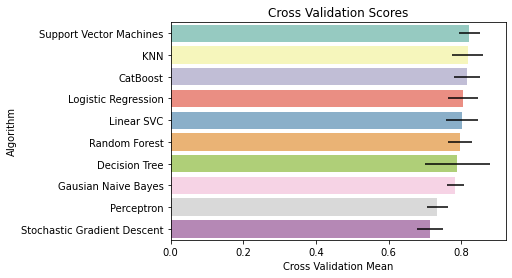

In [163]:
sns.barplot('Cross Validation Mean', 'Algorithm', data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Algorithm'], palette = 'Set3', **{'xerr': cv_std})
plt.ylabel('Algorithm')
plt.title('Cross Validation Scores')

As we can see, support vector machines has the highest cross validation mean and thus we will proceed with this model.

# Hyperparameter tuning for SVM
Hyperparameter tuning is the process of tuning the parameters of a model. Here I will tune the parameters of support vector classifier using GridSearchCV.

In [164]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

grid.fit(X_train, Y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.757 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.778 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.727 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.716 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.739 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.814 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.818 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.784 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.761 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.818 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.718 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [165]:
print("Best parameters: ", grid.best_params_) 
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimator:  SVC(C=100, gamma=0.01)


In [166]:
# Training accuracy

svc = SVC(C = 100, gamma = 0.01, kernel = 'rbf')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.54

In [167]:
# Mean cross validation score

cross_val_score(svc, X_train, Y_train, scoring = 'accuracy', cv = 10).mean()

0.8297242083758938

Our mean cross validation score improved slightly.

In [168]:
# Survival predictions by support vector classifier

Y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [169]:
len(Y_pred)

418

# Preparing data for submission

In [171]:
submission_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [173]:
submission_data.shape

(418, 2)

We want our submission dataframe to have 418 rows and 2 columns, PassengerId and Survived.

In [174]:
# Create submission dataframe

submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
submit.head()

,PassengerId,Survived
881,892,0
882,893,0
883,894,0
884,895,0
885,896,1


In [175]:
submit.shape

(418, 2)

In [177]:
# Create and save csv file 

submit.to_csv('./titanic_svm.csv',index = False)

## Possible extensions to improve model accuracy
1. Analyse ticket and cabin features
  - Do these features help predict passenger survival?
  - If yes, consider including them in the training set instead of dropping
2. Come up with alternative features in feature engineering
  - Is there any other features you can potentially create from existing features in the dataset
3. Remove features that are less important
  - Does removing features help reduce overfitting in the model?
4. Ensemble modelling
  - This is a more advanced technique whereby you combine prediction results from multiple machine learning models